## Behavior cloning
### Self-Driving Car Nanodegree. Project 3
In this project I'm going to train a deep neural network to drive a car like me.

In [1]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

Using TensorFlow backend.


In [2]:
label_file = '../data/p3/data/driving_log.csv'
data_dir = '../data/p3/data/'
data = pd.read_csv(label_file)[['center','left','right','steering']]

### Data exploration

In this project I'm using the dataset gathered by Udacity on the first track and provided to the students. Given dataset was enough for my model to drive around the track. As there was no such project requirement and model didn't reuqire this as well, I haven't recorded additonal data in the simulator by myself.

The given dataset consists from 7 fields: urls of images from 3 cameras as well as steering angle, throttle, break and speed. There are 8036 samples in the given dataset.

In [3]:
pd.read_csv(label_file).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8036 entries, 0 to 8035
Data columns (total 7 columns):
center      8036 non-null object
left        8036 non-null object
right       8036 non-null object
steering    8036 non-null float64
throttle    8036 non-null float64
brake       8036 non-null float64
speed       8036 non-null float64
dtypes: float64(4), object(3)
memory usage: 439.5+ KB


In [4]:
pd.read_csv(label_file).head(2)

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.14829
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.87963


I'm going to use just the images and steering angle for the current project.

In [5]:
pd.read_csv(label_file).steering.describe()

count    8036.000000
mean        0.004070
std         0.128840
min        -0.942695
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: steering, dtype: float64

The steering angle varies from -1 to 1 values with mean equal to 0 and standard deviation - 0.1288.  
Below we could look at the distribution of steering angles in a given dataset:

(array([  4.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   2.00000000e+00,
          2.00000000e+00,   2.00000000e+00,   1.10000000e+01,
          1.00000000e+01,   4.90000000e+01,   3.10000000e+01,
          4.10000000e+01,   1.39000000e+02,   1.07000000e+02,
          1.07000000e+02,   3.41000000e+02,   4.70000000e+02,
          3.46000000e+02,   4.61000000e+03,   3.93000000e+02,
          3.00000000e+02,   3.71000000e+02,   3.41000000e+02,
          6.40000000e+01,   1.12000000e+02,   1.03000000e+02,
          2.50000000e+01,   2.10000000e+01,   1.70000000e+01,
          0.00000000e+00,   6.00000000e+00,   5.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          2.00000000e+00]),
 array([-0.9426954 , -0.89412801, -0.84556063, -0.79699324, -0.74842586,
        -0.69985847, -0.65129109, -0.60272371, -0.55415632, -0.50558894,
        -0.45702155,

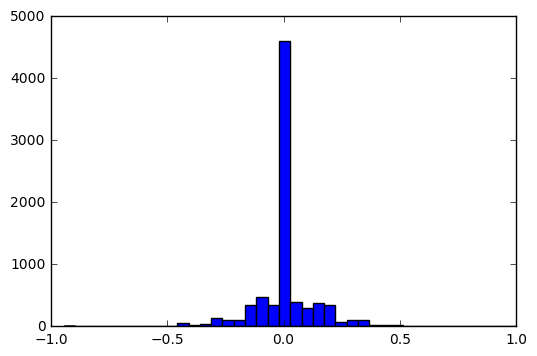

In [6]:
plt.hist(data.steering, bins = 40)

In the given dataset most of the images corresponds to straight forward movement (and steering angle 0). In order to avoid model bias, caused by unbalanced training set, I should generate additional samples with steering angle not equal to zero

Given training data consists from the images from 3 frontal camera: left, center and right. Each image has size 320x160 pixels and visualize the image of the road and landscape. Below we can see an example of the image from the camera.

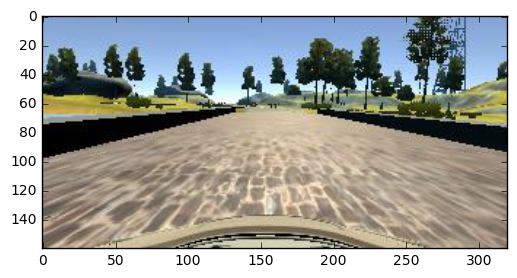

In [7]:
plt.imshow(plt.imread(data_dir+data.center.iloc[0].strip()))

### Image transformation

I guess, that the full image is not required to train my network. Landscape and other features may even concern the model. So I'm cropping unnecassary parts to use just the image of the road further. This also increase the speed of training and make the model lighter.

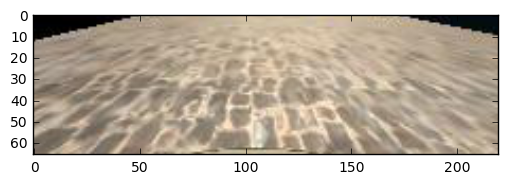

In [10]:
plt.imshow(plt.imread(data_dir+data.center.iloc[0].strip())[frame:frame+height,50:270,:])

#### Choosing the training data and recovery path
For the training data set images from the camera will be used as features and steering angle as labels. One of the key elements of car's behavior cloning is to train the car how to come back from the side of the road back to the center. That is called "recovery path". Emperically, I've finished the preparation of my training set using the following logic:  
1.  From the given dataset I'm choosing the samples with steering angle 0 and taking the image from the central camera, label 0.0.
2.  For the samples with non-zero steering angle I'm using images from 3 cameras. For the image from central camera I'm using the given angle as a ground truth. For the images from right and left cameras I'm applying coefficient so, that for example for the right turn, image from the left camera get steering angle multiplied on coef. (1.1 in my case) and for the left - steering angle divided by a coef. This technique helps me to train the recovery path of the car.
3.  On the dataset histogram above we've mentioned that dataset has much more images with the steering anle 0. To avoid model bias I'm generating additional images from the non-zero angle smaples inplace by flipping the images with non-zero steering angles and changing the sign of the corresponding steering angle. This provides additional samples to train the model.

I might want to use other geometry/light image transformations to improve the model performance but, at this point of time, I've received working model just with the mentioned approach.

In [9]:
# choose left image is turn to the right, etc.
frame = 74
height = 66
koef=1.1

arr_size = 6*len(data[data.steering!=0])+len(data[data.steering==0])
X_train=np.empty((arr_size,height,220,3))
y_train=np.empty((arr_size))


for i,val in enumerate(data[data.steering!=0].iterrows()):        
        X_train[6*i] = plt.imread(data_dir + val[1].center.strip())[frame:frame+height,50:270,:]
        y_train[6*i] = val[1].steering

        X_train[6*i+1] = X_train[2*i][:,::-1]
        y_train[6*i+1] = -1*y_train[2*i]

        if val[1].steering>0:
            X_train[6*i+2] = plt.imread(data_dir + val[1].left.strip())[frame:frame+height,50:270,:]
            y_train[6*i+2] = val[1].steering*koef

            X_train[6*i+3] = plt.imread(data_dir + val[1].right.strip())[frame:frame+height,50:270,:]
            y_train[6*i+3] = val[1].steering/koef

            X_train[6*i+4] = X_train[6*i+2][:,::-1]
            y_train[6*i+4] = y_train[6*i+2]*-1

            X_train[6*i+5] = X_train[6*i+3][:,::-1]
            y_train[6*i+5] = y_train[6*i+3]*-1
        else:
            X_train[6*i+2] = plt.imread(data_dir + val[1].left.strip())[frame:frame+height,50:270,:]
            y_train[6*i+2] = val[1].steering/koef

            X_train[6*i+3] = plt.imread(data_dir + val[1].right.strip())[frame:frame+height,50:270,:]
            y_train[6*i+3] = val[1].steering*koef

            X_train[6*i+4] = X_train[6*i+2][:,::-1]
            y_train[6*i+4] = y_train[6*i+2]*-1

            X_train[6*i+5] = X_train[6*i+3][:,::-1]
            y_train[6*i+5] = y_train[6*i+3]*-1
        
        
for i,val in enumerate(data[data.steering==0].iterrows()):
        X_train[i + 6*len(data[data.steering!=0])] = plt.imread(data_dir + val[1].center.strip())[frame:frame+height,50:270,:]
        y_train[i + 6*len(data[data.steering!=0])] = 0.0        

Here is the distribution of the dataset after described pre-processing steps.

(array([  2.00000000e+00,   4.00000000e+00,   2.00000000e+00,
          5.00000000e+00,   5.00000000e+00,   4.00000000e+00,
          5.00000000e+00,   1.40000000e+01,   1.70000000e+01,
          3.20000000e+01,   6.80000000e+01,   1.20000000e+02,
          2.52000000e+02,   3.61000000e+02,   6.08000000e+02,
          7.40000000e+02,   1.61100000e+03,   2.31700000e+03,
          3.07100000e+03,   2.05000000e+03,   6.33300000e+03,
          2.84800000e+03,   2.07300000e+03,   1.73700000e+03,
          7.00000000e+02,   5.52000000e+02,   3.87000000e+02,
          2.25000000e+02,   1.24000000e+02,   5.40000000e+01,
          3.40000000e+01,   1.90000000e+01,   1.40000000e+01,
          5.00000000e+00,   2.00000000e+00,   5.00000000e+00,
          3.00000000e+00,   0.00000000e+00,   6.00000000e+00,
          2.00000000e+00]),
 array([-1.1  , -1.045, -0.99 , -0.935, -0.88 , -0.825, -0.77 , -0.715,
        -0.66 , -0.605, -0.55 , -0.495, -0.44 , -0.385, -0.33 , -0.275,
        -0.22 , -0.165

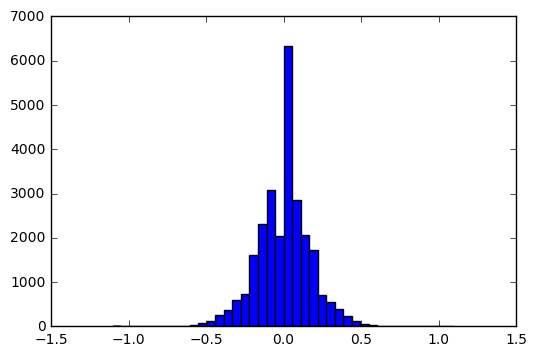

In [11]:
plt.hist(y_train, bins =40)

In [12]:
print('The training dataset consists from {} images with the size {} x {} and {} color channels'
      .format(X_train.shape[0],X_train.shape[2],X_train.shape[1],X_train.shape[3]))

The training dataset consists from 26411 images with the size 220 x 66 and 3 color channels


### Network
In order to train the car to drive, I've used the architecture of neural network, created by NVIDIA in the End to End Learning for Self-Driving Cars article[1]. 
  
The network consists of 9 layers, including a normalization layer, 5 convolutional layers
and 3 fully connected layers. Strided convolutions are used in the first three convolutional layers with a 2×2 stride and a 5×5 kernel and a non-strided convolution with a 3×3 kernel size in the last two convolutional layers. Convnets are followed by 3 fully connected. Activation function is ELU (exponential linear unit).

  
The last fully connected layer has a single output which predicts continuos value of steering angle.
  
Using described dataset and NVIDIA's model, the car could successfully drive through the track.
However, in order to manage possible overfitting, the dropout layers were added before first fully connected layer.
  
I'm using mean squared error metric to minimize loss during the back propogation iterations and Adam optimizer.
In order to decrease the training time of the model, when the validation loss isn't decreasing, I'm using early stopping function of Keras.

During the training, I'm splitting the data into training and validation datasets with the proportion 80:20 using Keras built-in function.



### The model and weights are saved in 2 files and might be used further in order to validate the model in a car simulator.

In [11]:
akt = 'elu'
init = 'he_normal'

model = Sequential()
model.add(Lambda(lambda x: x/128 - 1., input_shape=(66, 220, 3), output_shape=(66, 220, 3)))
model.add(Convolution2D(24, 5, 5, subsample = (2, 2), input_shape=(66, 220, 3),
                        border_mode='valid',activation=akt, init=init))
model.add(Convolution2D(36, 5, 5, subsample = (2, 2), border_mode='valid',activation=akt, init=init))
model.add(Convolution2D(48, 5, 5, subsample = (2, 2), border_mode='valid',activation=akt, init=init))

model.add(Convolution2D(64, 3, 3, subsample = (1, 1), border_mode='valid',activation=akt, init=init))
model.add(Convolution2D(64, 3, 3, subsample = (1, 1), border_mode='valid',activation=akt, init=init))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(100,activation=akt, init=init))
model.add(Dense(50, activation=akt, init=init))
model.add(Dense(10, activation=akt, init=init))
model.add(Dense(1, init=init))

model.compile(loss='mean_squared_error', optimizer='adam')


from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

model.fit(np.asarray(X_train), np.asarray(y_train), nb_epoch=10, batch_size=32, validation_split=0.2,
          callbacks=[early_stopping])

Train on 21128 samples, validate on 5283 samples
Epoch 1/10
21128/21128 [==============================] - 124s - loss: 0.1217 - val_loss: 0.0075
Epoch 2/10
21128/21128 [==============================] - 123s - loss: 0.0238 - val_loss: 0.0076
Epoch 3/10
21128/21128 [==============================] - 123s - loss: 0.0204 - val_loss: 0.0098
Epoch 4/10
21128/21128 [==============================] - 123s - loss: 0.0188 - val_loss: 0.0074
Epoch 5/10
21128/21128 [==============================] - 123s - loss: 0.0175 - val_loss: 0.0116
Epoch 6/10
21128/21128 [==============================] - 123s - loss: 0.0167 - val_loss: 0.0081
Epoch 7/10
21128/21128 [==============================] - 122s - loss: 0.0160 - val_loss: 0.0107


In [12]:
json_string = model.to_json()
model.save_weights("model.h5")

with open("model.json", "w") as json_file:
    json_file.write(json_string)
print("Saved model to disk")

Saved model to disk


### Reflection (Conclusions)
I find the usage of deep neural network in general and convolutional neural network in particular exciting to teach the machines do the human job.
Quite a simple network, which might be trained with 20k input images during 10 minutes, makes it possible to drive the track by itself. Amazin! (I've spent more time to learn driving this track).  
  
### Limitations of the study
In the current track the car was trained to drive in this particular track and new road might be challenging for this model. However, this track was not hard coded and if I keep training process of the existing model with new data, the car could drive further and choose the right moves on a new roads.

### References
1. End to End Learning for Self-Driving Cars. Mariusz Bojarski  
Davide Del Testa, Daniel Dworakowski, Bernhard Firner, Beat Flepp, Prasoon Goyal, Lawrence D. Jackel, Mathew Monfort, Urs Muller, Jiakai Zhang, Xin Zhang, Jake Zhao, Karol Zieba. 2016  
https://arxiv.org/pdf/1604.07316v1.pdf